In [1]:
# load modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from matplotlib.colors import ListedColormap

/home/lubo/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Summary tables

In [2]:
raw_data="../raw_data"
data_path=f"{raw_data}/phyl_placement/Suthaus_2022/vampyrellida/downstream_analyses/tax_assignment/tax_assign_summary_table.tsv"

sum_table=pd.read_csv(data_path, sep="\t")

In [3]:
sum_table

,otu_id,sample_id,lwr,taxopath
0,0839853ce3690d3c59a2d7cd42ea129c,A3,0.926500,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
1,80f49b9008a21d1bd6f1f1e8f4141ad9,A3,1.000000,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
2,00d88e1a2b4a6dbc357779d624208b48,allsamples,0.000015,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
3,0839853ce3690d3c59a2d7cd42ea129c,allsamples,0.889200,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
4,084e07bed6d405882c51c4761b10319c,allsamples,0.014950,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
...,...,...,...,...
117,472118fe46f7c580e02ea4275241ddb0,Th38,0.000233,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
118,70b7cf2cb7c70245a8ea9a860886dbce,Th38,1.000000,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
119,472118fe46f7c580e02ea4275241ddb0,Th40,0.000233,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...
120,24321d950a776becc82a94429481b330,X17007,0.991600,Eukaryota;Rhizaria;Cercozoa;Endomyxa;Vampyrell...


In [4]:
# Adjust summary table

# get rid off allsamples otus
sum_table=sum_table[sum_table["sample_id"] != "allsamples"]

# get sample as a categorical variable into indicator (1/0) variable
sum_table=pd.get_dummies(sum_table, columns=["sample_id"], prefix="", prefix_sep="")

# split the taxopath column into individual columns (each for one taxon level)
taxpath_labels=["Kingdom", "Domain", "Phyllum", "Class", "Order", "Family", "Genus", "Species"]
sum_table[taxpath_labels]=sum_table["taxopath"].str.split(pat=";", expand=True)
sum_table=sum_table.drop(columns=["taxopath"])

sum_table.sort_values(by="otu_id", inplace=True)

In [5]:
# save as tsv
raw_data="../raw_data"
data_path=f"{raw_data}/phyl_placement/Suthaus_2022/vampyrellida/downstream_analyses/results"

sum_table.to_csv(f"{data_path}/summary_table.tsv", sep="\t", index=False)

## Comparing taxonomic assignment and phylogenetic placement methods

### Load data

In [6]:
# taxonomic assignment table
project="Suthaus_2022"
marker="Full18S"
cell="cellCombined"
sim="sim99"
raw_data="../raw_data"
data_path=f"{raw_data}/OTU_results/{project}/otu_summary_table_{marker}_{cell}_{sim}.tsv"
tax_assign=pd.read_csv(data_path, sep="\t")
tax_assign=tax_assign[tax_assign["Order"] == "Vampyrellida"] # filter only vampyrellids
tax_assign=tax_assign.drop(columns=["Sequence"]) # drop the sequence column that we don't need

In [7]:
# phylogenetic placement
project="Suthaus_2022"
raw_data="../raw_data"
data_path=f"{raw_data}/phyl_placement/{project}/vampyrellida/downstream_analyses/tax_assignment/tax_assign_summary_table.tsv"

phyl_placement=pd.read_csv(data_path, sep="\t")
phyl_placement=phyl_placement[phyl_placement["sample_id"] == "allsamples"]
# split the taxopath column into individual columns (each for one taxon level)
taxpath_labels=["Kingdom", "Domain", "Phyllum", "Class", "Order", "Family", "Genus", "Species"]
phyl_placement[taxpath_labels]=phyl_placement["taxopath"].str.split(pat=";", expand=True)
phyl_placement=phyl_placement.drop(columns=["taxopath"])

In [8]:
# prepare data for plotting
tax_levels=["Order", "Family", "Genus", "Species"]
data={"taxonomy": [],
     "count": [],
     "method": []}

for tax_level in tax_levels:
    # loop for the taxonomic assignment part
    data["taxonomy"].append(tax_level)
    data["count"].append(tax_assign[tax_level].count())
    data["method"].append("taxonomic assignment")
    # loop for the phylogenetic placement part
    data["taxonomy"].append(tax_level)
    data["count"].append(phyl_placement[tax_level].count())
    data["method"].append("phylogenetic placement")

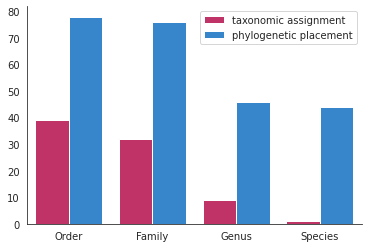

In [9]:
# plotting
project="Suthaus_2022"
raw_data="../raw_data"
data_path=f"{raw_data}/phyl_placement/{project}/vampyrellida/downstream_analyses/results"


sns.set_style("white")
sns.barplot(data=data, x="taxonomy", y="count", hue="method", palette=["#D81B60", "#1E88E5"])

sns.despine();

# save
plt.savefig(f"{data_path}/assignment_method_comparison.png", dpi=300, transparent=False, facecolor='white')

### Venn diagrams

In [10]:
# prepare input data for the venn diagrams

venn_data = {
    "Taxonomic Assignment": set(tax_assign["ID"].tolist()),
    "Phylogenetic Placement": set(phyl_placement["otu_id"].tolist())
}

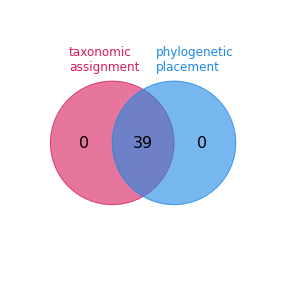

In [12]:
# plotting
# venn diagram using the pyvenn library: https://pypi.org/project/venn/

project="Suthaus_2022"
raw_data="../raw_data"
data_path=f"{raw_data}/phyl_placement/{project}/vampyrellida/downstream_analyses/results"

fig, ax1 = plt.subplots(figsize=(10,5), nrows=1, ncols=1)

c = venn(venn_data, 
         alpha=0.6, 
         figsize=(10, 5), 
         fontsize=16, 
         cmap=ListedColormap(["#D81B60", "#1E88E5"]), 
         ax=ax1)

ax1.get_legend().remove()
plt.text(0.20, # horizontal
         0.79, # vertical
         'taxonomic\nassignment', 
         fontsize=12, color='#D81B60')

plt.text(0.55, # horizontal
         0.79, # vertical
         'phylogenetic\nplacement', 
         fontsize=12, color='#1E88E5')

# save
plt.savefig(f"{data_path}/venn_assignment_method_comparison.png", dpi=300, transparent=False, facecolor='white')